/usr/local/lib/python3.10/dist-packages/albumentations/check_version.py:51: UserWarning: Error fetching version info <urlopen error [Errno -3] Temporary failure in name resolution>
  data = fetch_version_info()


Found 2052 validated image filenames belonging to 5 classes.
Found 684 validated image filenames belonging to 5 classes.
Found 684 validated image filenames belonging to 5 classes.
Epoch 1/5


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


65/65 ━━━━━━━━━━━━━━━━━━━━ 277s 3s/step - accuracy: 0.2319 - loss: 1.9368 - val_accuracy: 0.2939 - val_loss: 1.6040
Epoch 2/5
65/65 ━━━━━━━━━━━━━━━━━━━━ 91s 1s/step - accuracy: 0.2922 - loss: 1.6193 - val_accuracy: 0.4576 - val_loss: 1.3825
Epoch 3/5
65/65 ━━━━━━━━━━━━━━━━━━━━ 91s 1s/step - accuracy: 0.4334 - loss: 1.4137 - val_accuracy: 0.5029 - val_loss: 1.2540
Epoch 4/5
65/65 ━━━━━━━━━━━━━━━━━━━━ 91s 1s/step - accuracy: 0.4936 - loss: 1.2330 - val_accuracy: 0.4635 - val_loss: 1.1884
Epoch 5/5
65/65 ━━━━━━━━━━━━━━━━━━━━ 92s 1s/step - accuracy: 0.5952 - loss: 1.0169 - val_accuracy: 0.7208 - val_loss: 0.7897
22/22 ━━━━━━━━━━━━━━━━━━━━ 9s 390ms/step - accuracy: 0.7824 - loss: 0.7129
Final Test Accuracy: 0.7836257219314575


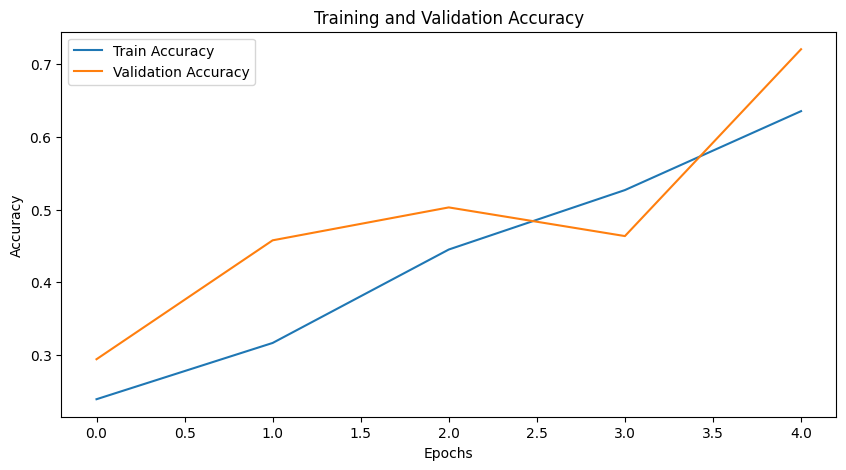

22/22 ━━━━━━━━━━━━━━━━━━━━ 9s 406ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


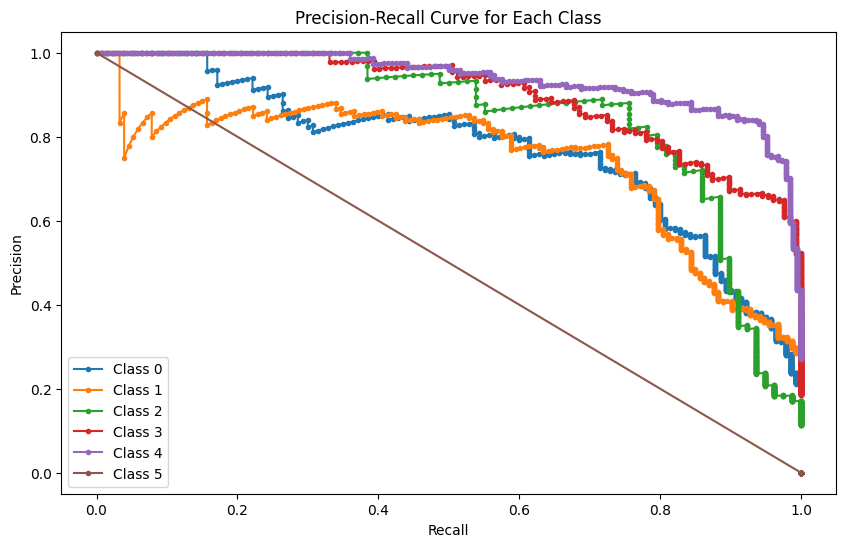

In [1]:
import os
import cv2
import numpy as np
import random
import albumentations as A
import matplotlib.pyplot as plt
import pandas as pd
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, concatenate, Conv2DTranspose, Dense, Flatten, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import precision_recall_curve

# Disable version check for albumentations
import albumentations.core.utils
albumentations.core.utils.check_version = lambda: None

# Set dataset paths
dataset_path = "/kaggle/input/thermal-images-diseased-healthy-leaves-paddy/thermal images UL"
output_path = "/kaggle/working/expanded_dataset"
final_dataset_path = "/kaggle/working/final_processed_dataset"

# Ensure only valid labels are considered
valid_labels = {"BLB", "Blast", "healthy", "hispa", "leaf folder", "leaf spot"}

# Create necessary directories
os.makedirs(output_path, exist_ok=True)
os.makedirs(final_dataset_path, exist_ok=True)

# Define augmentations
augmentations = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.Rotate(limit=45, p=0.5),
    A.RandomBrightnessContrast(p=0.5),
    A.GaussianBlur(p=0.3),
    A.RandomResizedCrop(height=256, width=256, scale=(0.7, 1.0), p=0.5),
    A.GridDistortion(p=0.3),
    A.ShiftScaleRotate(shift_limit=0.1, scale_limit=0.1, rotate_limit=30, p=0.5)
])

def apply_clahe(img):
    lab = cv2.cvtColor(img, cv2.COLOR_BGR2LAB)
    l, a, b = cv2.split(lab)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    l = clahe.apply(l)
    return cv2.cvtColor(cv2.merge((l, a, b)), cv2.COLOR_LAB2BGR)

def apply_filtering(img):
    return cv2.medianBlur(cv2.GaussianBlur(img, (5, 5), 0), 5)

def apply_thresholding(img):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    _, binary = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    return cv2.cvtColor(binary, cv2.COLOR_GRAY2BGR)

def apply_morphology(img):
    kernel = np.ones((5, 5), np.uint8)
    return cv2.morphologyEx(img, cv2.MORPH_CLOSE, kernel)

# Dataset expansion code
for label in os.listdir(dataset_path):
    if label not in valid_labels:
        continue
    label_path = os.path.join(dataset_path, label)
    save_path = os.path.join(output_path, label)
    os.makedirs(save_path, exist_ok=True)
    
    images = [os.path.join(label_path, img) for img in os.listdir(label_path)]
    
    while len(images) < 220:
        img_path = random.choice(images)
        try:
            img = cv2.imread(img_path)
            if img is None:
                continue
            augmented = augmentations(image=img)["image"]
            cv2.imwrite(os.path.join(save_path, f"aug_{len(images)}.jpg"), augmented)
            images.append(img_path)
        except Exception as e:
            print(f"Error processing {img_path}: {e}")
            continue

# Apply Processing Techniques
for label in os.listdir(output_path):
    if label not in valid_labels:
        continue
    label_path = os.path.join(output_path, label)
    save_label_path = os.path.join(final_dataset_path, label)
    os.makedirs(save_label_path, exist_ok=True)
    
    for img_file in os.listdir(label_path):
        try:
            img_path = os.path.join(label_path, img_file)
            img = cv2.imread(img_path)
            if img is None:
                continue
            
            cv2.imwrite(os.path.join(save_label_path, f"orig_{img_file}"), img)
            cv2.imwrite(os.path.join(save_label_path, f"clahe_{img_file}"), apply_clahe(img))
            cv2.imwrite(os.path.join(save_label_path, f"filtered_{img_file}"), apply_filtering(img))
            cv2.imwrite(os.path.join(save_label_path, f"thresh_{img_file}"), apply_thresholding(img))
            cv2.imwrite(os.path.join(save_label_path, f"morph_{img_file}"), apply_morphology(img))
        except Exception as e:
            print(f"Error processing {img_file}: {e}")
            continue

# Data loading and splitting
all_images, all_labels = [], []
label_map = {label: idx for idx, label in enumerate(valid_labels)}

for label in valid_labels:
    label_path = os.path.join(final_dataset_path, label)
    if not os.path.exists(label_path):
        continue
    for img_file in os.listdir(label_path):
        img_path = os.path.join(label_path, img_file)
        if os.path.exists(img_path):
            all_images.append(img_path)
            all_labels.append(label_map[label])

if not all_images:
    raise Exception("No valid images found in the dataset")

train_imgs, temp_imgs, train_labels, temp_labels = train_test_split(all_images, all_labels, test_size=0.4, stratify=all_labels, random_state=42)
val_imgs, test_imgs, val_labels, test_labels = train_test_split(temp_imgs, temp_labels, test_size=0.5, stratify=temp_labels, random_state=42)

# Compute class weights
class_weights = compute_class_weight("balanced", classes=np.unique(all_labels), y=all_labels)
class_weight_dict = {i: class_weights[i] for i in range(len(class_weights))}

# Convert labels to strings
train_labels = list(map(str, train_labels))
val_labels = list(map(str, val_labels))
test_labels = list(map(str, test_labels))

# Data generator
datagen = ImageDataGenerator(rescale=1./255)

# Data generators with error handling
train_gen = datagen.flow_from_dataframe(
    pd.DataFrame({"filename": train_imgs, "class": train_labels}),
    x_col="filename",
    y_col="class",
    target_size=(256, 256),
    batch_size=32,
    class_mode="sparse"
)

val_gen = datagen.flow_from_dataframe(
    pd.DataFrame({"filename": val_imgs, "class": val_labels}),
    x_col="filename",
    y_col="class",
    target_size=(256, 256),
    batch_size=32,
    class_mode="sparse"
)

test_gen = datagen.flow_from_dataframe(
    pd.DataFrame({"filename": test_imgs, "class": test_labels}),
    x_col="filename",
    y_col="class",
    target_size=(256, 256),
    batch_size=32,
    class_mode="sparse",
    shuffle=False
)

# Define U-Net model for classification
def build_unet_classifier(input_shape, num_classes):
    inputs = Input(input_shape)
    
    # Encoder
    conv1 = Conv2D(64, 3, activation='relu', padding='same')(inputs)
    conv1 = Conv2D(64, 3, activation='relu', padding='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    
    conv2 = Conv2D(128, 3, activation='relu', padding='same')(pool1)
    conv2 = Conv2D(128, 3, activation='relu', padding='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    
    conv3 = Conv2D(256, 3, activation='relu', padding='same')(pool2)
    conv3 = Conv2D(256, 3, activation='relu', padding='same')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    
    # Bridge
    conv4 = Conv2D(512, 3, activation='relu', padding='same')(pool3)
    conv4 = Conv2D(512, 3, activation='relu', padding='same')(conv4)
    
    # Decoder
    up5 = concatenate([Conv2DTranspose(256, 2, strides=(2, 2), padding='same')(conv4), conv3], axis=3)
    conv5 = Conv2D(256, 3, activation='relu', padding='same')(up5)
    conv5 = Conv2D(256, 3, activation='relu', padding='same')(conv5)
    
    up6 = concatenate([Conv2DTranspose(128, 2, strides=(2, 2), padding='same')(conv5), conv2], axis=3)
    conv6 = Conv2D(128, 3, activation='relu', padding='same')(up6)
    conv6 = Conv2D(128, 3, activation='relu', padding='same')(conv6)
    
    up7 = concatenate([Conv2DTranspose(64, 2, strides=(2, 2), padding='same')(conv6), conv1], axis=3)
    conv7 = Conv2D(64, 3, activation='relu', padding='same')(up7)
    conv7 = Conv2D(64, 3, activation='relu', padding='same')(conv7)
    
    # Classification head
    pool = MaxPooling2D(pool_size=(4, 4))(conv7)
    flat = Flatten()(pool)
    dense1 = Dense(256, activation='relu')(flat)
    dropout1 = Dropout(0.5)(dense1)
    dense2 = Dense(128, activation='relu')(dropout1)
    dropout2 = Dropout(0.5)(dense2)
    outputs = Dense(num_classes, activation='softmax')(dropout2)
    
    model = Model(inputs=inputs, outputs=outputs)
    return model

# Create and compile model
model = build_unet_classifier((256, 256, 3), len(valid_labels))
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Train with error handling
try:
    history = model.fit(
        train_gen,
        validation_data=val_gen,
        epochs=5,  # Changed from 10 to 5
        class_weight=class_weight_dict
    )

    # Evaluate model
    test_loss, test_accuracy = model.evaluate(test_gen)
    print("Final Test Accuracy:", test_accuracy)

    # Plot training history
    plt.figure(figsize=(10, 5))
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.title('Training and Validation Accuracy')
    plt.show()

    # Compute and plot PR curve
    num_classes = len(valid_labels)
    y_true = tf.keras.utils.to_categorical(test_gen.classes, num_classes)
    y_probs = model.predict(test_gen)

    plt.figure(figsize=(10, 6))
    for i in range(num_classes):
        precision, recall, _ = precision_recall_curve(y_true[:, i], y_probs[:, i])
        plt.plot(recall, precision, marker='.', label=f'Class {i}')

    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve for Each Class')
    plt.legend()
    plt.show()

except Exception as e:
    print(f"An error occurred during training: {e}")